In [29]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

In [2]:
df = pd.read_csv('dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df.info()


C:\Users\Gerlando\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 183990 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          183990 non-null  object 
 1   tourney_name        183990 non-null  object 
 2   surface             183828 non-null  object 
 3   draw_size           183990 non-null  float64
 4   tourney_level       183990 non-null  object 
 5   tourney_date        183990 non-null  object 
 6   match_num           183990 non-null  float64
 7   winner_id           183990 non-null  float64
 8   winner_entry        25616 non-null   object 
 9   winner_name         183990 non-null  object 
 10  winner_hand         183990 non-null  object 
 11  winner_ioc          183990 non-null  object 
 12  winner_age          181170 non-null  float64
 13  loser_id            183990 non-null  float64
 14  loser_entry         43753 non-null   object 
 15  loser_name          183990 non-nul

In [3]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['tourney_year'] = df['tourney_date'].dt.year

### functions

In [4]:
def create_new_colums(winner_attr, loser_attr, attr):
    col1=df[['winner_name',winner_attr]]
    col2=df[['loser_name',loser_attr]]
    col2.rename(columns={'loser_name': 'winner_name'}, inplace = True)
    col2.rename(columns={loser_attr: winner_attr}, inplace = True)
    name2 = col1.append(col2) 
    name2.rename(columns={'winner_name': 'name',winner_attr:attr}, inplace = True)
    name2.drop_duplicates(inplace=True)
    return name2


In [5]:
def create_df(series):
    tmp = pd.DataFrame(series)
    tmp.reset_index(inplace=True)
    return tmp

def count_occ(df, attr_to_count):
    tmp = df[attr_to_count].value_counts(dropna=False)
    tmp = create_df(tmp)
    return tmp

## Dataframe with Players profile

#### matches' number per player

In [6]:
#matches won per player
num_matches_won = count_occ(df, 'winner_name')
num_matches_won.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#matches loss per player
num_matches_loss = count_occ(df, 'loser_name')
num_matches_loss.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#total matches per player
num_matches = num_matches_won.append(num_matches_loss)
num_matches = num_matches.groupby(['name']).num_matches.sum()
num_matches = create_df(num_matches)
num_matches.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#drop players with few matches
num_matches = num_matches[num_matches['num_matches'] > 2]

#add ratio
num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
num_matches['ratio'] = num_matches['num_matches_won']/num_matches['num_matches']
num_matches.fillna(0, inplace = True)

del num_matches['num_matches_won'] #reduntant column

#RENAME our database
player_profile = num_matches
player_profile

,name,num_matches,ratio
0,AALIYA EBRAHIM,9,0.222222
1,AALIYAH HOHMANN,3,0.333333
2,AALYKA EBRAHIM,4,0.000000
3,AANU AYEGBUSI,6,0.500000
4,AARON ADDISON,11,0.181818
...,...,...,...
6633,ZUZANA BOHATOVA,6,0.000000
6634,ZUZANA PAVELEKOVA,4,0.500000
6635,ZUZANA ZALABSKA,3,0.666667
6636,ZUZANA ZLOCHOVA,179,0.519553


## Statistics of players during period

In [7]:
years=df['tourney_year'].unique()
years.sort()
for year in years:
    num_matches_year = df[df['tourney_year']==year] #takes only matches of a year
    num_m_y = 'num_matches_'+str(year)
    
    #matches won per player
    num_matches_won = count_occ(num_matches_year, 'winner_name')
    num_matches_won.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #matches loss per player
    num_matches_loss = count_occ(num_matches_year, 'loser_name')
    num_matches_loss.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #total matches per player
    num_matches = num_matches_won.append(num_matches_loss)
    num_matches = num_matches.groupby(['name'])[num_m_y].sum()
    num_matches = create_df(num_matches)
    num_matches.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #add ratio
    num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
    num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
    num_matches['ratio_'+str(year)] = num_matches['num_matches_won']/num_matches[num_m_y]
    num_matches.fillna(0, inplace = True)
    del num_matches['num_matches_won']
    
    #add to our player profile ratio and matches of current year
    player_profile = pd.merge(player_profile, num_matches, how = 'left', on = 'name')
    player_profile.fillna(0, inplace = True) #players with no matches during a year

player_profile
    

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6633,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000
6634,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000
6635,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
6636,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000


## Player's Hand

In [8]:
df_hand=create_new_colums('winner_hand','loser_hand','hand')
#df_hand.at[180480, 'hand'] = 'R'#AGGIUSTARE QUESTA COSA
df_hand.drop_duplicates(inplace=True)

player_profile=pd.merge(player_profile, df_hand, how='left', on='name')
player_profile

c:\users\gerlando\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R


## Player's Gender

In [9]:
df_gender = create_new_colums('winner_gender','loser_gender','gender')
player_profile = pd.merge(player_profile, df_gender, how='left', on='name')
player_profile

c:\users\gerlando\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F


## Player's nationality

In [10]:
df_ioc = create_new_colums('winner_ioc','loser_ioc','ioc')
df_ioc.drop_duplicates(inplace=True)

player_profile = pd.merge(player_profile, df_ioc, how='left', on='name')
player_profile

c:\users\gerlando\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK


## ages of players 

In [11]:
df['winner_birth']=df['tourney_year']-df['winner_age']
df['loser_birth']=df['tourney_year']-df['loser_age']

#winner_bith
winner_birth=df.groupby(['winner_name']).winner_birth.min() #print(gg.groupby(['winner_name']).birth.min())
winner_birth = create_df(winner_birth)
winner_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#loser_birth
loser_birth = df.groupby(['loser_name']).loser_birth.min() #print(gg.groupby(['loser_name']).birth.min())
loser_birth = create_df(loser_birth)
loser_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#players_birth
name_birth = winner_birth.append(loser_birth)
name_birth.dropna(inplace=True)
name_birth.drop_duplicates(inplace=True)
name_birth = name_birth.groupby(name_birth['name']).birth.min()
name_birth = create_df(name_birth)

player_profile = pd.merge(player_profile, name_birth, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0


## height of players

In [12]:
df_ht=create_new_colums('winner_ht','loser_ht','ht')
df_ht.dropna(inplace=True)
df_ht.drop_duplicates(inplace=True)
df_ht = df_ht.groupby(['name']).ht.max() 

player_profile=pd.merge(player_profile, df_ht, how='left', on='name')
player_profile

#completare aggiungendo l'altezza media tramite le nazionalità dei giocatori

c:\users\gerlando\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000


### Minutes

In [13]:
#mean winner minutes
win_min =df.groupby('winner_name').minutes.mean()
win_min = create_df(win_min)
win_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean loser minutes
loser_min = df.groupby('loser_name').minutes.mean()
loser_min = create_df(loser_min)
loser_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean player minutes
player_min = win_min.append(loser_min)
player_min = player_min.groupby('name').minutes.mean()

#add to player profile
player_profile = pd.merge(player_profile, player_min, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490


###### rapport ace/svpt 

è il rapporto tra gli ace fatti e il numero di "battute" effettuate durante un match

svpt = numero di battute totali = numero di prime battute (1stIN) + numero di seconde battute (secondo tentativo se sbagli il primo, questo attributo non viene fornito ma è ricavabile)

### Percentage ace

fare la percetuale rispetto a tutti i servizi fatti oppure rispetto solo al primo servizio? la prof consiglia rispetto al primo servizio. Online dicono che un ace al secondo servizio è raro

In [14]:
#table tot ace per player 
win_ace =df.groupby('winner_name').w_ace.sum()
win_ace = create_df(win_ace)
win_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

loser_ace =df.groupby('loser_name').l_ace.sum()
loser_ace = create_df(loser_ace)
loser_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

player_ace = win_ace.append(loser_ace)
player_ace = player_ace.groupby('name').ace.sum()

#table tot 1stIn per player
win_1stIn =df.groupby('winner_name').w_1stIn.sum()
win_1stIn= create_df(win_1stIn)
win_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

loser_1stIn =df.groupby('loser_name').l_1stIn.sum()
loser_1stIn = create_df(loser_1stIn)
loser_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

player_1stIn= win_1stIn.append(loser_1stIn)
player_1stIn = player_1stIn.groupby('name').p_1stIn.sum()


p = pd.merge(player_ace, player_1stIn, how = 'left', on = 'name')
p['perc_ace'] = round((p['ace'] / p['p_1stIn'])*100, 0)
del p['ace']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0


In [15]:
win_1stwon =df.groupby('winner_name').w_1stWon.sum()
win_1stwon = create_df(win_1stwon)
win_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

loser_1stwon =df.groupby('loser_name').l_1stWon.sum()
loser_1stwon = create_df(loser_1stwon)
loser_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

player_1stwon= win_1stwon.append(loser_1stwon)
player_1stwon = player_1stwon.groupby('name').p_1stwon.sum()

p = pd.merge(player_1stIn, player_1stwon, how = 'left', on = 'name')
p['_1stwon_1stIn'] = (p['p_1stwon'] / p['p_1stIn']) *100
del p['p_1stwon']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955


#### total_won_service / total_service

In [16]:
#total service
win_svpt =df.groupby('winner_name').w_svpt.sum()
win_svpt = create_df(win_svpt)
win_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

loser_svpt =df.groupby('loser_name').l_svpt.sum()
loser_svpt = create_df(loser_svpt)
loser_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

player_svpt= win_svpt.append(loser_svpt)
player_svpt = player_svpt.groupby('name').svpt.sum()

player_svpt

name
AADA INNA                 74.0
AALISHA ALEXIS           112.0
AALIYA EBRAHIM           581.0
AALIYAH HOHMANN          168.0
AALYKA EBRAHIM           260.0
                        ...   
ZUZANA ZALABSKA          217.0
ZUZANA ZLOCHOVA        14041.0
ZUZANNA BEDNARZ          130.0
ZUZANNA SZCZEPANSKA      181.0
ZVONIMIR ORESKOVIC        34.0
Name: svpt, Length: 10086, dtype: float64

In [17]:
#winner second service won
win_2ndwon =df.groupby('winner_name').w_2ndWon.sum()
win_2ndwon = create_df(win_2ndwon)
win_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#loser second service won
loser_2ndwon =df.groupby('loser_name').l_2ndWon.sum()
loser_2ndwon = create_df(loser_2ndwon)
loser_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#player second service won
player_2ndwon= win_2ndwon.append(loser_2ndwon)
player_2ndwon = player_2ndwon.groupby('name').p_2ndwon.sum()

player_2ndwon

name
AADA INNA                 0.0
AALISHA ALEXIS            0.0
AALIYA EBRAHIM            0.0
AALIYAH HOHMANN           0.0
AALYKA EBRAHIM            0.0
                        ...  
ZUZANA ZALABSKA           0.0
ZUZANA ZLOCHOVA        1746.0
ZUZANNA BEDNARZ           0.0
ZUZANNA SZCZEPANSKA       0.0
ZVONIMIR ORESKOVIC        3.0
Name: p_2ndwon, Length: 10086, dtype: float64

In [18]:
#total number of service won (1st won + 2nd won)
total_serv_won = pd.merge(player_1stwon, player_2ndwon, how = 'left', on = 'name')
total_serv_won['total_won'] = total_serv_won['p_1stwon'] + total_serv_won['p_2ndwon']
total_serv_won.drop(['p_1stwon', 'p_2ndwon'], axis=1, inplace=True)

#calculate ratio: total_serv_won / total_serve
tot = pd.merge(total_serv_won, player_svpt, how = 'left', on = 'name')
tot['serv_won_tot_seve'] = tot['total_won'] / tot['svpt']
tot.drop(['total_won', 'svpt'], axis=1, inplace=True)

player_profile = pd.merge(player_profile, tot, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999


### breakpoints
total number of breakpoints for each player

In [19]:
def sum_col(df, gb_attr, attr_to_count, n_gb_attr, n_attr_to_count):
    player =df.groupby(gb_attr)[attr_to_count].sum()
    player = create_df(player)
    player.set_axis([n_gb_attr, n_attr_to_count], axis=1, inplace=True)
    return player


In [20]:
#breakpoints faced
win_bpfaced = sum_col(df, 'winner_name', 'w_bpFaced', 'name', 'bpFaced')
loser_bpfaced = sum_col(df, 'loser_name', 'l_bpFaced', 'name', 'bpFaced')
player_bpfaced = win_bpfaced.append(loser_bpfaced)
player_bpfaced = player_bpfaced.groupby('name').bpFaced.sum()

player_profile = pd.merge(player_profile, player_bpfaced, how = 'left', on = 'name')

#breakpoints saved
win_bpsaved = sum_col(df, 'winner_name', 'w_bpSaved', 'name', 'bpsaved')
loser_bpsaved = sum_col(df, 'loser_name', 'l_bpSaved', 'name', 'bpsaved')
player_bpsaved = win_bpsaved.append(loser_bpsaved)
player_bpsaved = player_bpsaved.groupby('name').bpsaved.sum()

player_profile = pd.merge(player_profile, player_bpsaved, how = 'left', on = 'name')

player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,79.0,40.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000,18.0,5.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,36.0,16.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000,39.0,21.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,55.0,23.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,31.0,17.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000,25.0,14.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999,1560.0,789.0


### perc_df and perc_df_2ndIn
percentage of double faults respect first serve and second serve

In [21]:
#double faults
win_df = sum_col(df, 'winner_name', 'w_df', 'name', 'df')
loser_df= sum_col(df, 'loser_name', 'l_df', 'name', 'df')
player_df = win_df.append(loser_df)
player_df = player_df.groupby('name').df.sum()

#% double faults
p = pd.merge(player_df, player_1stIn, how = 'left', on = 'name')
p['perc_df'] = round((p['df'] / p['p_1stIn'])*100, 0)
del p['df']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,79.0,40.0,0.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000,18.0,5.0,0.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,36.0,16.0,0.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000,39.0,21.0,0.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,55.0,23.0,0.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,31.0,17.0,0.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000,25.0,14.0,0.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999,1560.0,789.0,11.0


In [22]:
#percetage of double faults respect to 2ndserve
player_2ndIn = pd.merge(player_svpt, player_1stIn, how = 'left', on = 'name')
player_2ndIn['p_2ndIn'] = player_2ndIn['svpt'] - player_2ndIn['p_1stIn']
player_2ndIn.reset_index(inplace = True)
del player_2ndIn['svpt'] 
del player_2ndIn['p_1stIn']

p = pd.merge(player_df, player_2ndIn, how = 'left', on = 'name')
p['perc_df_2ndIn'] = round((p['df'] / p['p_2ndIn'])*100, 0)
del p['df']
del p['p_2ndIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,79.0,40.0,0.0,0.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000,18.0,5.0,0.0,0.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,36.0,16.0,0.0,0.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000,39.0,21.0,0.0,0.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,55.0,23.0,0.0,0.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,31.0,17.0,0.0,0.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000,25.0,14.0,0.0,0.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999,1560.0,789.0,11.0,20.0


### perc_2ndwon
percentage of second won


In [23]:
player_perc2w = pd.merge(player_2ndwon, player_2ndIn, how = 'left', on = 'name')
player_perc2w['perc_2ndwon'] = round((player_perc2w['p_2ndwon'] / player_perc2w['p_2ndIn'])*100, 0)
del player_perc2w['p_2ndwon']
del player_perc2w['p_2ndIn']

player_profile = pd.merge(player_profile, player_perc2w, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,79.0,40.0,0.0,0.0,0.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000,18.0,5.0,0.0,0.0,0.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,36.0,16.0,0.0,0.0,0.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000,39.0,21.0,0.0,0.0,0.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,55.0,23.0,0.0,0.0,0.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,31.0,17.0,0.0,0.0,0.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000,25.0,14.0,0.0,0.0,0.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999,1560.0,789.0,11.0,20.0,36.0


### PtsSG and PtsLSG
points played per service game and
points lost per service game.
FORSE NON è FATTIBILE PERCHè NON SAPPIAMO IN QUALE SET FA IL PUNTO?

### perc_v_ace_
ace rate against the player

In [24]:
#ace against
win_v_ace = sum_col(df, 'winner_name', 'l_ace', 'name', 'v_ace')
loser_v_ace = sum_col(df, 'loser_name', 'w_ace', 'name', 'v_ace')

player_v_ace = win_v_ace.append(loser_v_ace)
player_v_ace = player_v_ace.groupby('name').v_ace.sum()
#player_v_ace.isin([0]).sum()

In [25]:
#1stIn against
win_v_1stIn = sum_col(df, 'winner_name', 'l_1stIn', 'name', 'v_1stIn')
loser_v_1stIn = sum_col(df, 'loser_name', 'w_1stIn', 'name', 'v_1stIn')

player_v_1stIn= win_v_1stIn.append(loser_v_1stIn)
player_v_1stIn = player_v_1stIn.groupby('name').v_1stIn.sum()

In [26]:
player_perc_v_ace = pd.merge(player_v_ace, player_v_1stIn, how = 'left', on = 'name')
player_perc_v_ace['perc_v_ace'] = round((player_perc_v_ace['v_ace'] / player_perc_v_ace['v_1stIn'])*100, 0)
del player_perc_v_ace['v_ace']
del player_perc_v_ace['v_1stIn']

player_profile = pd.merge(player_profile, player_perc_v_ace, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.0,0.0,0.000000,R,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,79.0,40.0,0.0,0.0,0.0,0.0
1,AALIYAH HOHMANN,3,0.333333,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,3.0,0.333333,U,F,DEU,NaN,NaN,60.000000,0.0,0.000000,0.000000,18.0,5.0,0.0,0.0,0.0,0.0
2,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.0,0.0,0.000000,U,F,IND,NaN,NaN,60.000000,0.0,0.000000,0.000000,36.0,16.0,0.0,0.0,0.0,0.0
3,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.0,0.0,0.000000,U,F,NGR,NaN,NaN,60.000000,0.0,0.000000,0.000000,39.0,21.0,0.0,0.0,0.0,1.0
4,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.0,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.0,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,55.0,23.0,0.0,0.0,0.0,0.0
6635,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.0,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,31.0,17.0,0.0,0.0,0.0,0.0
6636,ZUZANA ZALABSKA,3,0.666667,3.0,0.666667,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,R,F,CZE,1986.0,175.785714,60.000000,0.0,0.000000,0.000000,25.0,14.0,0.0,0.0,0.0,0.0
6637,ZUZANA ZLOCHOVA,179,0.519553,51.0,0.627451,16.0,0.1875,44.0,0.636364,50.0,0.500000,10.0,0.4,8.0,0.125000,R,F,SVK,1990.0,172.500000,61.210490,0.0,63.363955,0.536999,1560.0,789.0,11.0,20.0,36.0,2.0


### v_df
Double faults rate against

### v_1stwon
first serve return points won DALL'AVVERSARIO, NON è POSSIBILE CALCOLARLO PER IL GIOCATORE

### v_2ndwon
second serve return points won

### list tourney 


### CORRELATION

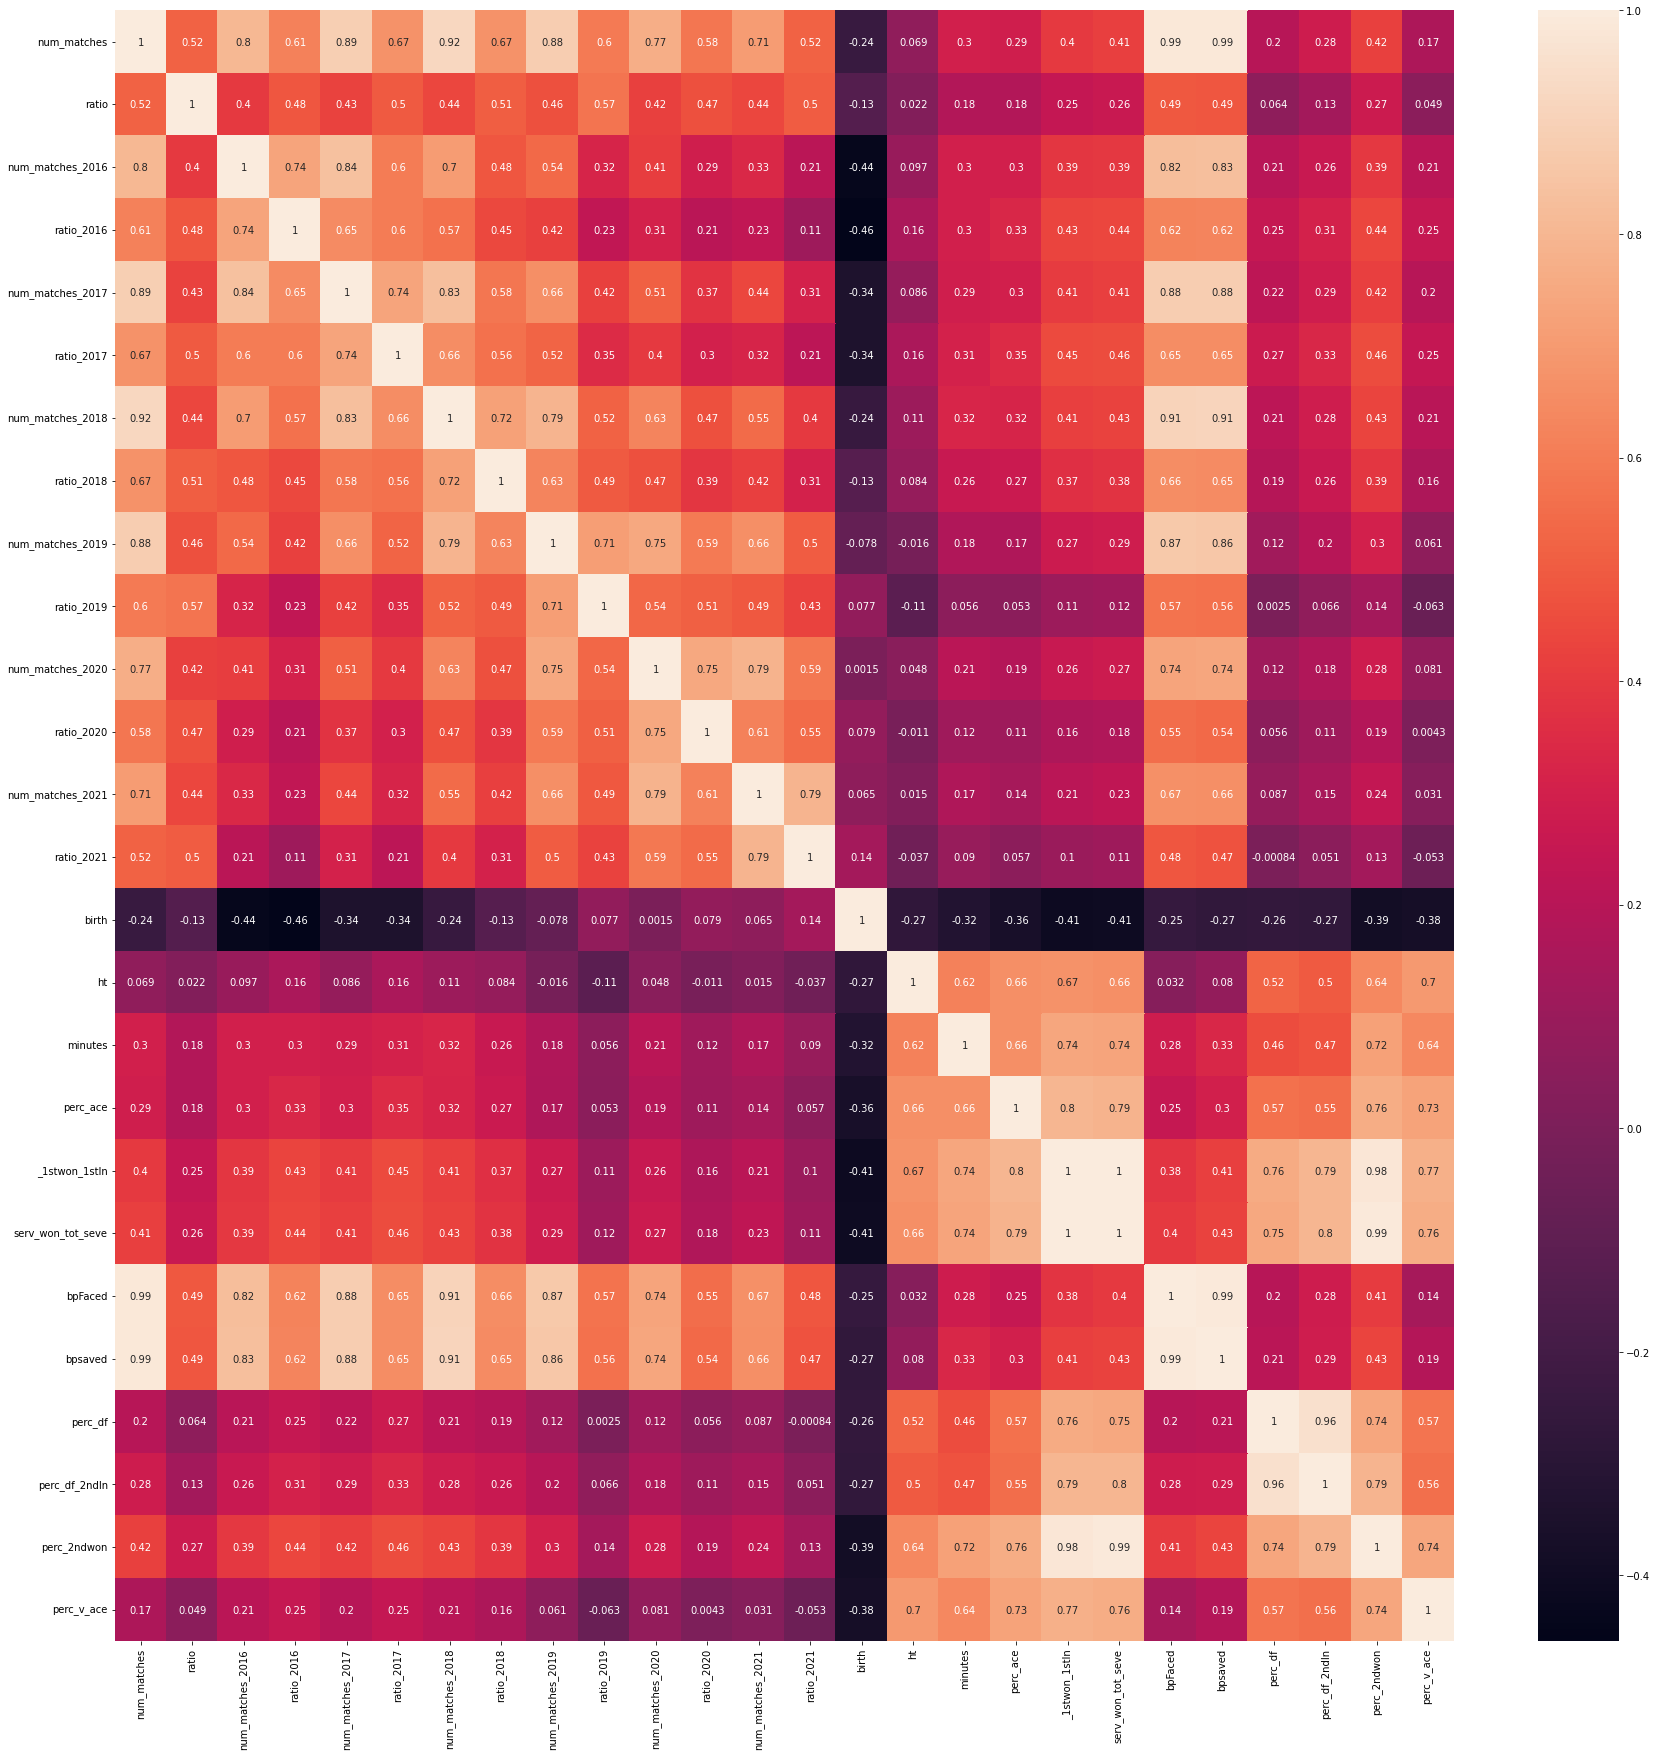

In [30]:
matrix = player_profile.corr()
fig, ax = plt.subplots(figsize=(30, 30))         # Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()